# SPIRE Aperture Photometry for Point Sources

The method is for photmetry is outlined in [the SPIRE Handbook](http://herschel.esac.esa.int/Docs/SPIRE/spire_handbook.pdf), section 5.12.1. This notebook just shows one practical example.

The workflow is the following:
1. Using `ESASky` module of `astroquery` search for the source in _Herschel_ observations. Pick on observation for the example.
2. Download the map using the [astroquery.esasky](https://astroquery.readthedocs.io/en/latest/esasky/esasky.html) results.
3. Perform aperture photometry using [photutils](https://photutils.readthedocs.io/en/stable).
4. Bonus: compare the aperture-derived flux density with the one in the SPIRE point source catalogue, also available in `astroquery.esasky`.

For this exercise we are going to use a known stellar calibrator: $\beta$ And, with RA=01:09:43.9, Dec= +35:37:14.

For reference, the model flux densities of $\beta$ And in the SPIRE bands ([Decin et al. 2007](https://ui.adsabs.harvard.edu/#abs/2007A&A...472.1041D)) are (430, 217, 105) mJy at (250, 350, 500) µm. 

In [1]:
import numpy as np

# Set up matplotlib and use a nicer set of plot parameters
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [46]:
from astropy.io import fits
from astropy.wcs import WCS
from astropy.visualization import PercentileInterval, ImageNormalize
from astropy import units as u
from astropy.coordinates import SkyCoord
from photutils import SkyCircularAperture, SkyCircularAnnulus, aperture_photometry
from astropy.table import hstack

from astroquery.esasky import ESASky

In [28]:
#
# We'll seacrh ESASky for $\beta$ And directly, using the Simbad name resolver
maps = ESASky.query_region_maps("beta And", radius="6 arcsec",missions=['Herschel'])
#
# Note, this will download the maps in Maps sub-folder

In [29]:
print (maps["HERSCHEL"].info)
maps["HERSCHEL"]["observation_id","filter","duration"].pprint()

<Table masked=True length=45>
      name       dtype  format
--------------- ------- ------
   postcard_url  object       
    product_url  object       
 observation_id  object       
observation_oid   int32       
         ra_deg float64 {!r:>}
        dec_deg float64 {!r:>}
    target_name  object       
     instrument  object       
         filter  object       
     start_time  object       
       duration float64 {!r:>}
          stc_s  object       

observation_id     filter    duration
-------------- ------------- --------
    1342224965 250, 350, 500    583.0
    1342259256      100, 160    152.0
    1342223338      100, 160    276.0
    1342248031      100, 160    152.0
    1342263815 250, 350, 500    583.0
    1342248033      100, 160    276.0
    1342223336       70, 160    276.0
    1342237161      100, 160    276.0
    1342212508       70, 160    276.0
    1342199613      100, 160    276.0
           ...           ...      ...
    1342237163       70, 160    152.0
   

In [30]:
#Let's pick up SPIRE observation, i.e. one that has 250, 350, and 500 µm
# one example is 13422263815, this is index 4, we remove all the rest
nher = len(maps["HERSCHEL"])
ikeep = 4
maps["HERSCHEL"].remove_rows(np.delete(range(nher),ikeep))
maps["HERSCHEL"]["observation_id","filter","duration"].pprint()

observation_id     filter    duration
-------------- ------------- --------
    1342263815 250, 350, 500    583.0


In [31]:
# now we can download the map
maps_data = ESASky.get_maps(maps)

Starting download of HERSCHEL data. (1 files)
INFO: Maps available at /Users/ivaltcha/Dropbox/Work/Python/herspy/notebooks/Maps [astroquery.esasky.core]


In [41]:
#
# extract the HDU for the maps in a dictionary
# there should be only one index [0]
hdu = {}
spire_bands = ['250','350','500']
for band in spire_bands:
    hdu[band] = maps_data["HERSCHEL"][0][band]

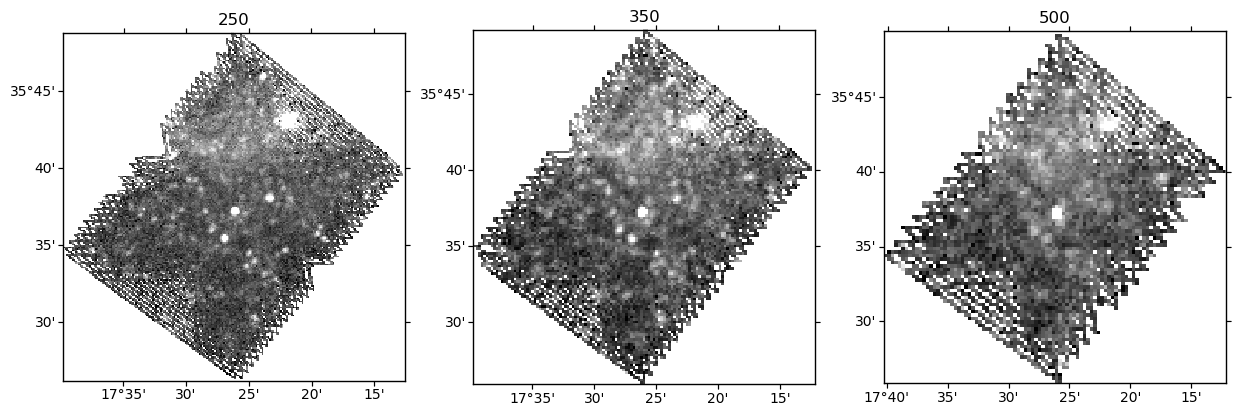

In [59]:
#
# Display the three SPIRE maps, will use colour interval is 98%.
# nan are messing the normalization, so will take care of it
#
fig = plt.figure(figsize=(15,5),dpi=100)
pp = 98.0 # 
for k,band in enumerate(spire_bands):
    wcs = WCS(hdu[band]['image'].header)
    ax = fig.add_subplot(1,3,k+1,projection=wcs)
    ax.set_title("%s"%band)
    ximage = hdu[band]['image']
    norm = ImageNormalize(ximage.data[~np.isnan(ximage.data)], interval=PercentileInterval(pp))
    ax.imshow(ximage.data,norm=norm,cmap=plt.cm.gray,origin='lower',interpolation='nearest')

## Converting the input maps from MJy/sr to Jy/pixel

To do aperture photmetry we need to convert the SPIRE maps, which are in units of `Jy/beam` to `Jy/pixel`. 

These are the steps, as explained in the SPIRE Handbook:
1. Convert to point-source calibration by dividing by `KPtoE`
2. Divide by $\Omega_\mathrm{pipe}$

After these two steps the maps should be in `Jy/pixel`

In [60]:
#
# Using the SPIRE Handbook we copy the necessary parameters
#
KPtoE = {'250': 90.646, '350': 51.181, '500': 23.580}

omega_pipe = {'250': 469.35, '350': 831.27, '500': 1804.31} # arcsec^2
for band in spire_bands:
    wcs = WCS(hdu[band]['image'].header)
    pixscale = wcs.wcs.cdelt[1]*3600.0
    hdu[band]['image'].data = pixscale**2*hdu[band]['image'].data/KPtoE[band]/omega_pipe[band]
    hdu[band]['image'].header['BUNIT'] = 'Jy/pixel'

Now the maps are in Jy/pixel. Let's define the coordinates of the target $\beta$ Andromeda:

In [61]:
# beta And coordinates
ra_c = 17.43504
dec_c = 35.62010
beta_And = SkyCoord(ra=ra_c * u.deg, dec=dec_c * u.deg, frame='icrs')
#

And define the apertures for the target, and the background. We use the aperture sizes as described in the SPIRE Handbook, table 5.8.

In [62]:
aperture = dict()
aperture['250'] = SkyCircularAperture(beta_And, r=22. * u.arcsec)
aperture['350'] = SkyCircularAperture(beta_And, r=30. * u.arcsec)
aperture['500'] = SkyCircularAperture(beta_And, r=40. * u.arcsec)
# now the background annuli
back = SkyCircularAnnulus(beta_And, r_in = 60.0*u.arcsec, r_out=90.0*u.arcsec)

Next is the actual measurement of the total flux within the target aperture and the background annulus. We do the background subtraction within the loop over the bands.

Few comments:
* the aperture areas can only be calculated if the aperture is conveted to pixels. To do this the method to_pixlel() needs a WCS.
* The final result is in Jy

In [72]:
photo = dict()
bkg_photo = dict()
result = dict()
for band in spire_bands:
    photo[band] = aperture_photometry(hdu[band]['image'], aperture[band])
    bkg_photo[band] = aperture_photometry(hdu[band]['image'], back)
    wcs = WCS(hdu[band]['image'].header)
    bkg_area = back.to_pixel(wcs).area()
    aper_area = aperture[band].to_pixel(wcs).area()
    result[band] = photo[band]['aperture_sum'][0] - aper_area*bkg_photo[band]['aperture_sum'][0]/bkg_area
    print ("{},{:.4f} Jy".format(band,result[band].value))

250,0.3280 Jy
350,0.1782 Jy
500,0.0939 Jy


Fow all the subsequent corrections we need the source spectrum, as the calculated flux density is for a source with $\nu F_\nu$ = const. Our assumption is that in the SPIRE bands $\beta$ And has a powerlaw spectrum with an index 2. In this case we can the tables in the SPIRE Handbook.

Next we need to apply the beam correction factor (Table 5.4 in Handbook).

In [73]:
kbeam = {'250': 1.0446, '350': 1.0434, '500': 1.0746} # powerlaw with alpha=2
for band in spire_bands:
    result[band] = result[band]*kbeam[band]
    print ("{},{:.4f} Jy".format(band,result[band].value))

250,0.3427 Jy
350,0.1860 Jy
500,0.1009 Jy


Next we need to apply the colour correction KColP (Table 5.6)

In [74]:
kcolp = {'250': 0.9454, '350': 0.9481, '500': 0.9432} # powerlaw with alpha=2
for band in spire_bands:
    result[band] = result[band]*kcolp[band]
    print ("{},{:.4f} Jy".format(band,result[band].value))

250,0.3239 Jy
350,0.1763 Jy
500,0.0952 Jy


And finally the aperture correction, which is also source SED dependent (Table 5.8). Note that we use the standard apertures of (22,30,40) arcsec. For different ones the user has to use the beam profiles from the SPIRE calibration context and dervie the correction.

In [75]:
kaper = {'250': 1.28, '350': 1.242, '500': 1.2610}
for band in spire_bands:
    result[band] = result[band]*kaper[band]
    print ("{},{:.4f} Jy".format(band,result[band].value))

250,0.4147 Jy
350,0.2190 Jy
500,0.1200 Jy


And finally let's compare with Decin et al. (2007) models:

In [80]:
model = {'250': 430, '350': 217, '500': 105} # mJy
print ('band,measured,model,model/measured')
for band in spire_bands:
    print ("{},{:.2f},{},{:.2f}".format(band,result[band].value*1000, model[band], model[band]/result[band].value/1000.0))


band,measured,model,model/measured
250,414.65,430,1.04
350,218.98,217,0.99
500,120.02,105,0.87


We can visualise the apertures and the background annuli just to make sure they make sense.

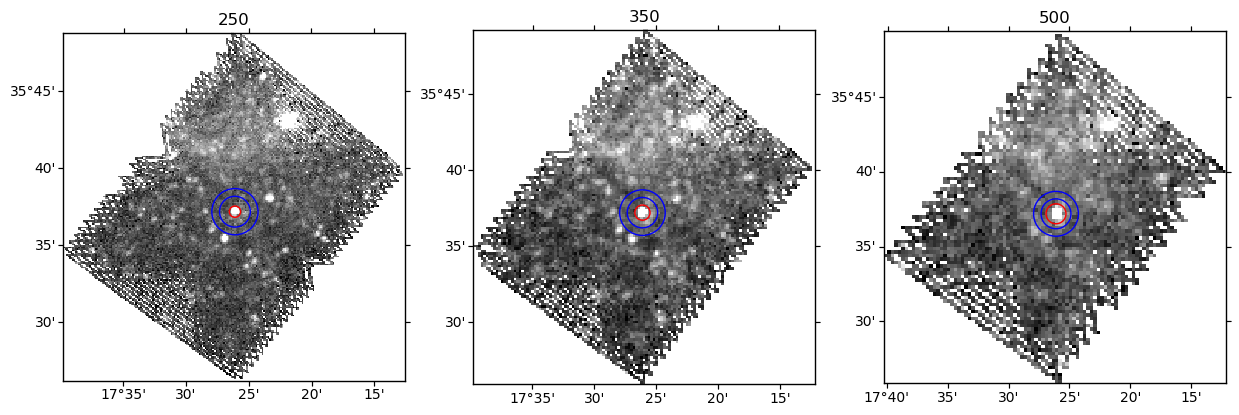

In [81]:
fig = plt.figure(figsize=(15,5),dpi=100)
pp = 98.0 # colour cut percentage
for k,band in enumerate(spire_bands):
    wcs = WCS(hdu[band]['image'].header)
    ax = fig.add_subplot(1,3,k+1,projection=wcs)
    ax.set_title("%s"%band)
    ximage = hdu[band]['image']
    norm = ImageNormalize(ximage.data[~np.isnan(ximage.data)], interval=PercentileInterval(pp))
    ax.imshow(ximage.data,norm=norm,cmap=plt.cm.gray,origin='lower',interpolation='nearest')
    aperture[band].to_pixel(wcs).plot(ax=ax,color='r')
    back.to_pixel(wcs).plot(ax=ax,color='b')